In [1]:
import sys
sys.path.append('..')
import ugent

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FixedLocator, FormatStrFormatter, ScalarFormatter

In [2]:
from pyslise import Pyslise
from math import exp, pi, cos
import numpy as np

# https://doi.org/10.17512/jamcm.2016.2.14
alpha = 1/4
V = lambda x: 100*cos(x)**2
a = 0
b = pi
N = 50

slp = Pyslise(V, a, b, tolerance=1e-13)
exact = np.array(list(zip(*slp.eigenvaluesByIndex(0, N, (0, 1), (0, 1))))[1])
exact

array([   9.74322102,   28.68513938,   46.47905847,   62.98648995,
         78.0627659 ,   91.80107129,  105.00295715,  119.05798835,
        135.0233565 ,  153.22568004,  173.64271367,  196.20767465,
        220.8737101 ,  247.61116492,  276.40072004,  307.22928486,
        340.08769166,  374.96934451,  411.86938957,  450.78418557,
        491.71095482,  534.64754706,  579.59227584,  626.54380291,
        675.50105505,  726.46316327,  779.42941779,  834.39923415,
        891.37212754,  950.34769302, 1011.32559025, 1074.30553144,
       1139.28727191, 1206.27060259, 1275.2553439 , 1346.24134097,
       1419.22845961, 1494.21658311, 1571.20560955, 1650.19544963,
       1731.18602482, 1814.17726585, 1899.16911143, 1986.16150716,
       2075.15440462, 2166.14776061, 2259.14153648, 2354.13569758,
       2451.13021276, 2550.12505394])

In [3]:
from math import sin, cos, sinh, cosh, sqrt

def eta(Z, count):
    eta = []
    
    if abs(Z) < 0.5:
        eta9 = [1.527349308567059e-009, 0.36365459727787e-10, 0.00395276736172e-10,
                0.00002635178241e-10, 0.00000012199899e-10, 0.00000000042069e-10,
                0.00000000000113e-10, 0]
        eta8 = [2.901963686277412e-008, 0.76367465428353e-9, 0.00909136493195e-9,
                0.00006587945603e-9, 0.00000032939728e-9, 0.00000000121999e-9,
                0.00000000000351e-9, 0.00000000000001e-9]

        e9 = 0
        e8 = 0
        z = 1
        for i in range(8):
            e9 += z * eta9[i]
            e8 += z * eta8[i]
            z *= Z

        eta = [0, 0, 0, 0, 0, 0, 0, 0, 0, e8, e9]
        for i in range(8, -1, -1):
            eta[i] = Z * eta[i + 2] + (2 * i + 1) * eta[i + 1];
        assert count <= len(eta)
        eta = eta[:count]
    else:
        eta = [0] * count;
        

        if Z > 0:
            assert Z <= 500, "Z > 500 is not supported"
            sZ = sqrt(Z)
            eta[0] = cosh(sZ)
            if count > 1:
                eta[1] = sinh(sZ) / sZ
        else:
            sZ = sqrt(-Z)
            eta[0] = cos(sZ)
            if count > 1:
                eta[1] = sin(sZ) / sZ

        for i in range(2, count):
            eta[i] = (eta[i - 2] - (2 * i - 3) * eta[i - 1]) / Z

    return tuple(eta)

In [4]:
from scipy.optimize import root_scalar

def solve(n, plot=False):
    xs = np.linspace(a, b,  n+1)
    grid = np.linspace(xs[:-1], xs[1:], 20)
    vecV = np.vectorize(V)
    steps = np.trapz(vecV(grid), grid, axis=0)/(grid[-1,:] - grid[0,:])
    
    def shoot(E, y, dy):
        for a, b, v in zip(xs[:-1], xs[1:], steps):
            z = v - E

            if plot:
                ab = np.linspace(a, b, 20)
                fs = [0]*len(ab)
                dfs = [0]*len(ab)
                for i, x in enumerate(ab):
                    h = x - a
                    c, s = eta(z*h**2, 2)
                    fs[i] = y * c + h * dy * s
                    dfs[i] = (y*z*h*s + dy*c)
                plt.plot(ab, fs, color="red")
                plt.plot(ab, dfs, color="blue")

            h = b - a
            c, s = eta(z*h**2, 2)
            y, dy = y*c + dy*h*s, y*z*h*s + dy*c

        return y, dy
    
    if not plot:
        r = []
        for e in exact:
            r.append(root_scalar(lambda E: shoot(E, 0, 1)[0], x0=.99*e, x1=1.01*e, rtol=1e-12).root)

        return r
    else:
        shoot(50, 0, 1)

solve(100)[:10]

[9.758060789982023,
 28.696665250355654,
 46.487240197345294,
 62.99127046642245,
 78.06415511157184,
 91.79955871299103,
 104.99986213382857,
 119.05475780988361,
 135.02064431005152,
 153.2235006620752]

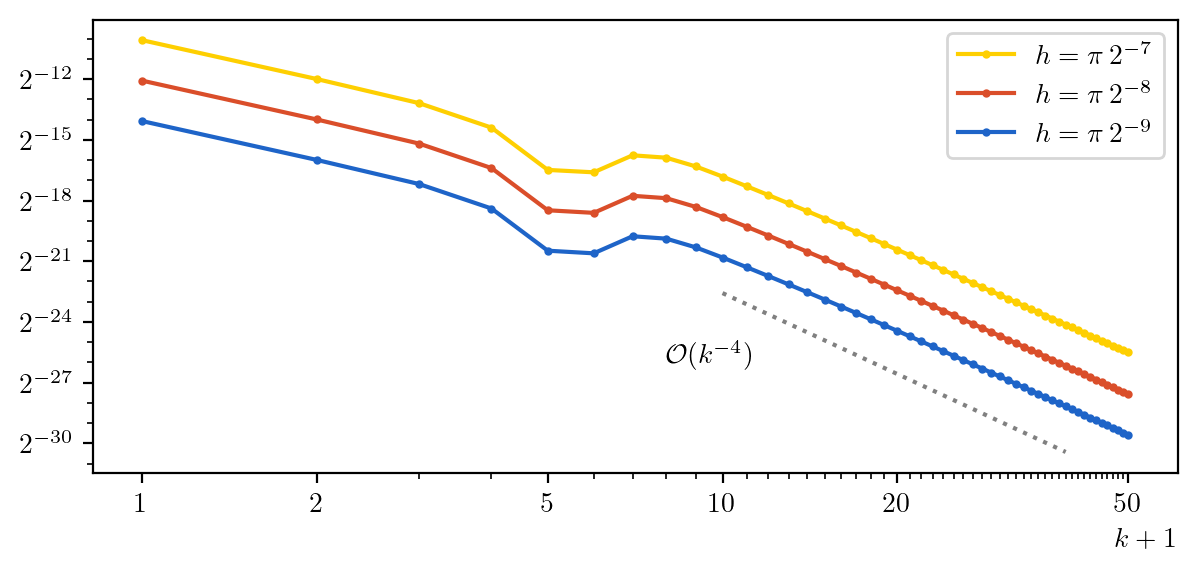

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FixedLocator, FormatStrFormatter, ScalarFormatter

fig, ax = plt.subplots(figsize=(7, 3), dpi=200)

ax.set_xscale('log', base=10)
ax.set_yscale('log', base=2)
ax.xaxis.set_major_locator(FixedLocator([1, 2, 5, 10, 20, 50]))
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_minor_locator(FixedLocator(range(1, N)))
ax.xaxis.set_minor_formatter(FormatStrFormatter(""))

ax.yaxis.set_major_locator(FixedLocator([2**-i for i in range(3, 40, 3)]))
ax.yaxis.set_minor_locator(FixedLocator([2**-i for i in range(1, 40, 1)]))
ax.yaxis.set_minor_formatter(FormatStrFormatter(""))


xs = np.array(range(10, N-10), dtype=float)
ax.plot(xs, xs**-4 * 1.6e-3, c="gray", ls=':')
ax.text(8, 2**-26, "$\\mathcal{O}(k^{-4})$")

for c, n in list(zip(ugent.palet, [128,256,512][::-1]))[::-1]:
    h = (b-a)/n
    hp2 = np.log2(h/pi)
    assert (round(hp2) - hp2) < 1e-5
    hp2 = round(hp2)
    
    found = solve(n)
    ax.plot(range(1, 1+len(found)), np.abs(exact[:len(found)] - found)/exact[:len(found)],
            label=f"$h = \\pi\,2^{{{hp2}}}$", c=c, marker='.', ms=4)
ax.legend()
ax.set_xlabel('$k+1$', loc='right')

plt.savefig('pruess_k_error.pdf', bbox_inches="tight")

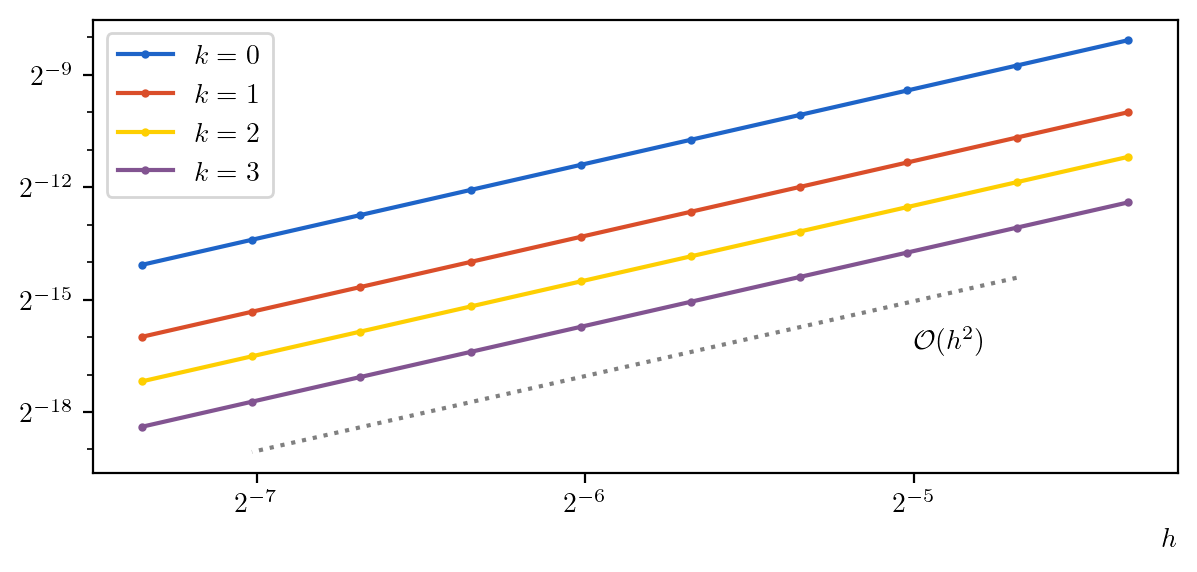

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FixedLocator, FormatStrFormatter, ScalarFormatter

fig, ax = plt.subplots(figsize=(7, 3), dpi=200)

ax.set_xscale('log', base=2)
ax.set_yscale('log', base=2)
# ax.xaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_minor_formatter(FormatStrFormatter(""))
ax.xaxis.set_minor_locator(FixedLocator([2**-i for i in range(1, 30, 1)]))

ax.yaxis.set_major_locator(FixedLocator([2**-i for i in range(3, 30, 3)]))
ax.yaxis.set_minor_locator(FixedLocator([2**-i for i in range(1, 30, 1)]))
ax.yaxis.set_minor_formatter(FormatStrFormatter(""))


ns = np.round(2**np.linspace(6, 9, 10))
ax.plot((b-a)/ns[1:-1], 1/ns[1:-1]**2 * 0.3, c="gray", ls=':')
ax.text(2**-5, 0.8*2**-16, "$\\mathcal{O}(h^2)$")

data = [[] for _ in range(4)]
for n in ns:
    found = solve(int(n))
    
    errors = np.abs(exact[:len(found)] - found)/exact[:len(found)]
    
    for c, f in zip(data, errors):
        c.append(f)

for k, (c, d) in enumerate(zip(ugent.palet, data)):
    ax.plot((b-a)/ns, d,
            label=f"$k = {k}$", c=c, marker='.', ms=4)
ax.legend(loc='upper left')
ax.set_xlabel('$h$', loc='right')

plt.savefig('pruess_h_error.pdf', bbox_inches="tight")